# 第五章

In [1]:
import MeCab
import CaboCha

In [2]:
import pydot

In [3]:
import re

In [4]:
m = MeCab.Tagger("-Ochasen")
c = CaboCha.Parser()

In [232]:
with open("neko.txt", "r", encoding="utf_8") as f:
    s = f.read()

## 40

In [6]:
class Morph():
    def __init__(self, data):
        self.surface = data[0]
        self.pos = data[1]
        self.pos1 = data[2]
        if self.pos in ('動詞', '助動詞', '形容詞'):
            self.base = data[7]
        else:
            self.base = data[0]
    
    def __str__(self):
        return self.surface

## 41

そもそも文ごとに分けるのはこっちでやれってことか…？
たぶんそう

In [34]:
class Chunk():
    def __init__(self, identifier, dst):
        self.morphs = []
        self.srcs = []
        self.dst = dst
        self.id = identifier
    
    def __str__(self):
        return "".join(map(lambda x: str(x).rstrip("、").rstrip("。"), self.morphs))

    def append_morph(self, morph):
        self.morphs.append(morph)
        
    def append_src(self, src):
        self.srcs.append(src)
        
    def has_noun(self):
        for m in self.morphs:
            if m.pos == '名詞':
                return True
        return False
    
    def has_verb(self):
        for m in self.morphs:
            if m.pos == "動詞":
                return True
        return False
    
    def get_verb(self):
        for m in self.morphs:
            if m.pos == '動詞':
                return m
        return None

    def get_postpos(self):
        for m in self.morphs:
            if m.pos == '助詞':
                return m
        return None

In [233]:
full = []
sentence = []
cur_chunk = None

for sent_raw in re.split(r"\u3000|\n", s):
    if not sent_raw:
        continue
        
    tree = c.parse(sent_raw)
    sentence = []
    for line in tree.toString(CaboCha.FORMAT_LATTICE).split("\n"):
        if line == "EOS":
            break
        
        data = re.split(r"[\t, ]", line)
        if data[0] == '*':
            if int(data[1]) > 0:
                sentence.append(cur_chunk)
            cur_chunk = None
            tar = int(data[2].rstrip("D")) 
            cur_chunk = Chunk(int(data[1]), tar if tar > 0 else None)
            continue
        
        morph = Morph(data)
        cur_chunk.morphs.append(morph)
    
    sentence.append(cur_chunk)
    for chunk in sentence:
        if chunk.dst:
            sentence[chunk.dst].append_src(chunk.id)
    
    full.append(sentence)   

うまくいっているかわからんけどなんかできた

## 41, 42

In [9]:
for sent in full[:8]:
    for chunk in sent:
        if chunk.dst:
            print("{}\t{}".format(chunk, sent[chunk.dst]))

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である


## 43

In [10]:
for sent in full[:8]:
    for chunk in sent:
        if chunk.dst and chunk.has_noun and sent[chunk.dst].has_verb:
            print("{}\t{}".format(chunk, sent[chunk.dst]))

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である


## 44

In [11]:
graph = pydot.Dot(graph_type='graph')

In [12]:
graph

In [13]:
from IPython.display import Image

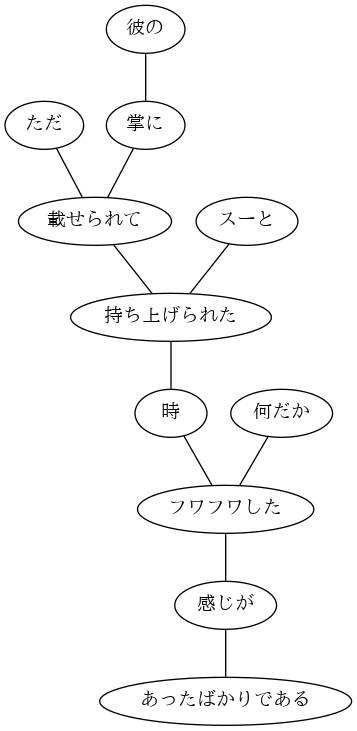

In [14]:
for sent in full[:10]:
    graph = pydot.Dot(graph_type='graph')
    for chunk in sent:
        if chunk.dst:
            graph.add_edge(pydot.Edge(str(chunk), str(sent[chunk.dst])))
Image(graph.create_png())

## 45

In [91]:
verbs = {}

def add_verb(verb, pp):
    if not verb in verbs:
        verbs[verb] = {}
    
    if not pp in verbs[verb]:
        verbs[verb][pp] = 0
    
    verbs[verb][pp] += 1
    return

In [92]:
for sentence in full:
    for chunk in sentence:
        if not chunk.has_verb():
            continue
        
        base = chunk.get_verb().base
        # print(base, end=" ")
        for src in chunk.srcs:
            pp = sentence[src].get_postpos()
            if pp:
                add_verb(str(base), str(pp))
                # print(pp, end=" ")
            
        # print()

ファイル出力

In [70]:
with open("verb_pattern.txt", "w", encoding="utf_8") as f:
    for i, v in verbs.items():
        print(" ".join([i] + list(map(lambda x: x[0], sorted(v.items(), key=lambda x: -x[1])))), file=f)

コーパス中で頻出する述語と格パターンの組み合わせ

In [73]:
verb_jointed = {"{} {}".format(pp, v):value for v, pats in verbs.items() for pp, value in pats.items() }

In [80]:
sorted(verb_jointed.items(), key=lambda x: -x[1])[:10]

[('を する', 1302),
 ('と 云う', 846),
 ('に する', 782),
 ('て する', 586),
 ('に なる', 542),
 ('が する', 515),
 ('が ある', 492),
 ('は する', 479),
 ('と する', 464),
 ('て 見る', 397)]

「する」「見る」「与える」の格パターン

In [81]:
from pprint import pprint

In [85]:
for tar in ['する', '見る', '与える']:
    print(tar)
    pprint(sorted(verbs[tar].items(), key=lambda x: -x[1])[:10])

する
[('を', 1302),
 ('に', 782),
 ('て', 586),
 ('が', 515),
 ('は', 479),
 ('と', 464),
 ('で', 248),
 ('から', 237),
 ('も', 150),
 ('の', 100)]
見る
[('て', 397),
 ('を', 173),
 ('は', 55),
 ('から', 51),
 ('で', 41),
 ('が', 41),
 ('に', 39),
 ('と', 32),
 ('か', 11),
 ('も', 11)]
与える
[('を', 16),
 ('に', 13),
 ('て', 8),
 ('は', 6),
 ('け', 1),
 ('で', 1),
 ('だけ', 1),
 ('じゃあ', 1),
 ('に対して', 1),
 ('も', 1)]


## 46

In [95]:
def obj_incr(obj, key):
    if not key in obj:
        obj[key] = 0
    
    obj[key] += 1
    return

In [104]:
for sentence in full[:20]:
    
    print("".join([str(c) for c in sentence]))
    
    for chunk in sentence:
        if not chunk.has_verb():
            continue
        
        base = chunk.get_verb().base
        this_verbs = {}
        this_chunks = {}
        
        for src in chunk.srcs:
            pp = sentence[src].get_postpos()
            if pp:
                obj_incr(this_verbs, str(pp))
                obj_incr(this_chunks, str(sentence[src]))
        
        print(base, end="\t")
        print(" ".join(map(lambda x: x[0], sorted(this_verbs.items(), key=lambda x: -x[1]))), end="\t")
        print(" ".join(map(lambda x: x[0], sorted(this_chunks.items(), key=lambda x: -x[1]))))
        
    if not this_verbs:
        continue


一
吾輩は猫である
名前はまだ無い
どこで生れたかとんと見当がつかぬ
生れる	で	どこで
つく	か が	生れたか 見当が
何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している
する		
泣く	で	所で
する	て だけ	泣いて いた事だけは
吾輩はここで始めて人間というものを見た
始める	で	ここで
見る	は を	吾輩は ものを
しかもあとで聞くとそれは書生という人間中で一番獰悪な種族であったそうだ
聞く	で	あとで
この書生というのは時々我々を捕えて煮て食うという話である
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
しかしその当時は何という考もなかったから別段恐しいとも思わなかった
思う	から	なかったから
ただ彼の掌に載せられてスーと持ち上げられた時何だかフワフワした感じがあったばかりである
載せる	に	掌に
持ち上げる	て と	載せられて スーと
する		
ある	が	感じが
掌の上で少し落ちついて書生の顔を見たのがいわゆる人間というものの見始であろう
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
この時妙なものだと思った感じが今でも残っている
思う	と	ものだと
残る	が でも	感じが 今でも
第一毛をもって装飾されべきはずの顔がつるつるしてまるで薬缶だ
する	をもって	第一毛をもって
する	が	顔が
その後猫にもだいぶ逢ったがこんな片輪には一度も出会わした事がない
逢う	に	猫にも
出会う	も	一度も
のみならず顔の真中があまりに突起している
のむ		
する	が	真中が
そうしてその穴の中から時々ぷうぷうと煙を吹く
吹く	から を	中から ぷうぷうと煙を
どうも咽せぽくて実に弱った
する		
弱る	て	咽せぽくて
これが人間の飲む煙草というものである事はようやくこの頃知った
飲む	の	人間の
知る	は	事は
この書生の掌の裏でしばらくはよい心持に坐っておったがしばらくすると非常な速力で運転し始めた
坐る	で に	裏で 心持に
おる	て	坐って
する		
する	が と で	おったが すると 速力で
書生が動くのか自分だけが動くのか分らないが無暗に眼が廻る
動く	が	書生が
動く	か だけ	動くのか 自分だけが
分る	か	動くのか
廻る	が	分らないが 眼が


コードきたねえな

## 47

In [135]:
with open("47_mining.txt", "w", encoding="utf_8") as f:
    for sentence in full:
        for ci, chunk in enumerate(sentence):
            for i, morph in enumerate(chunk.morphs):
                if morph.pos1 == "サ変接続" and str(chunk)[-1] == "を" and not morph == "--":
                    if sentence[chunk.dst].has_verb():
                        print(str(chunk) + sentence[chunk.dst].get_verb().base, file=f, end="\t")
                        joins = []
                        for src in sentence[chunk.dst].srcs:
                            if not src == ci:
                                joins.append([str(sentence[src].morphs[-1]), str(sentence[src])])
                        print(" ".join(map(lambda x: x[0], joins)), file=f, end="\t")
                        print(" ".join(map(lambda x: x[1], joins)), file=f)

頻出

In [142]:
with open("47_mining.txt", "r", encoding="utf_8") as f:
    s = f.read()

units = {}    

for line in s.split("\n"):
    line_sep = line.split("\t")
    pred = line_sep[0]
    if not pred in units:
        units[pred] = 0
    units[pred] += 1

In [145]:
sorted(units.items(), key=lambda x: -x[1])[:10]

[('返事をする', 29),
 ('挨拶をする', 21),
 ('話をする', 14),
 ('真似をする', 14),
 ('喧嘩をする', 11),
 ('質問をする', 8),
 ('運動をする', 7),
 ('昼寝をする', 6),
 ('話を聞く', 6),
 ('問答をする', 5)]

## 48

In [190]:
def string_paths(sentence, i, now = None):
    if not now:
        now = ""
    if not sentence[i].dst:
        return now + str(sentence[i])
    
    now += "{} -> ".format(sentence[i])   
    return string_paths(sentence, sentence[i].dst, now)

In [155]:
with open("48_path.txt", "w", encoding="utf_8") as f:
    for sentence in full:
        for ci, chunk in enumerate(sentence):
            if chunk.has_noun():
                print(print_paths(sentence, ci))

## 49

In [158]:
from itertools import combinations

In [212]:
import copy

In [222]:
import json

Pythonのdeepcopyも結局子dictまでしか作らない、孫はそのまま

In [300]:
# もらったpathを適宜X, Y置き換えしながら文字列で返す
def render_path(sentence, path, now = "", replace = {}):
    app_word = ""
    curr = path.pop(0)
        
    if curr in replace:
        replaced = False
        for m in sentence[curr].morphs:
            if m.pos == "名詞" and not replaced:
                app_word += replace[curr]
                replaced = True
            else:
                app_word += str(m)
    else:
        app_word = str(sentence[curr])
    
    if not path:
        # replace名詞が最後なら助詞つけないっぽい、二度手間だけどここで調整
        if curr in replace:
            app_word = ""
            for m in sentence[curr].morphs:
                if m.pos == "名詞":
                    app_word += replace[curr]
                    break
                else:
                    app_word += str(m)
        
        return now + app_word
    
    now += "{} -> ".format(app_word)
    return render_path(sentence, path, now, replace)

In [284]:
# ある地点から根までのpathを配列で返す
def get_path(sentence, start, now = None):
    if not now:
        now = []
    now.append(start)
    if not sentence[start].dst:
        return now
    return get_path(sentence, sentence[start].dst, now)

In [298]:
# x, yのパスを返すと欲しいやつが返ってくるすごい関数
def string_dual_path(sentence, path_x, path_y):

    x = path_x[0]
    y = path_y[0]
    
    # どちらかが根である場合
    if len(path_x) == 1:
        return render_path(sentence, path_y, replace={x: "X", y: "Y"})
    if len(path_y) == 1:
        return render_path(sentence, path_x, replace={x: "X", y: "Y"})
    
    # どちらかがルート上にある場合
    if y in path_x:
        cut = path_x.index(y)
        return render_path(sentence, path_x[:cut+1], replace={x: "X", y: "Y"})
    if x in path_y:
        cut = path_y.index(x)
        return render_path(sentence, path_x[:cut+1], replace={x: "X", y: "Y"})
        
    # 文節kで合流する場合
    ## kの地点を -i （最後からi番目）の形で求める（どうせ最後は同じ）
    i = -1
    while True:
        if path_x[i-1] != path_y[i-1]:
            break
        i -= 1
    
    rend_x = render_path(sentence, path_x[:i], replace={x: "X"})
    rend_y = render_path(sentence, path_y[:i], replace={y: "Y"})
    goal = str(sentence[i])
    
    return " | ".join([rend_x, rend_y, goal])
        

In [306]:
with open("49_nouns_path.txt", "w", encoding="utf_8") as f:
    for i, sentence in enumerate(full[:100]):
        print("{}/{}".format(i, 100))
        nouns = []
        for ci, chunk in enumerate(sentence):
            if chunk.has_noun():
                nouns.append(ci)

        if len(nouns) < 2:
            continue

        print("*", "".join(map(lambda x: str(x), sentence)), file=f)
        for x, y in combinations(nouns, 2):
            path_x = get_path(sentence, x)
            path_y = get_path(sentence, y)
            print(string_dual_path(copy.deepcopy(sentence), path_x, path_y), file=f)
    

0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


ファイルがでかくなるのが嫌なのでとりあえず100まで

おわり